In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import  entropy

from _analysis_functions import format_cols

### Generate Genome Usage Plot (Heatmap)

In [60]:
def check_genome_mag(genomes: pd.Series, name, fold:bool=True):
    bns = len(genomes[0])
    fig, (ax, dis) = plt.subplots(1,2, figsize=(0.75*bns,3), gridspec_kw={'width_ratios': [bns/2-1, 1]})
    np.random.seed(42)
    y_bins = np.arange(0, 0.55 if fold else 1.05, 0.05)
    density = np.zeros((len(y_bins) - 1, bns))

    genomes = np.stack(genomes.apply(lambda x: abs(abs(x-0.5)-0.5)).values) if fold else np.stack(genomes.values)

    for i in range(bns):
        hist, _ = np.histogram(genomes[:, i], bins=y_bins, density=True)
        density[:, i] = hist
    density /= 100

    distr = density.mean(axis=1)
    density[density!=0] = np.log(density[density!=0])
    density[density==0] = None



    im = ax.imshow(density,  aspect='auto', origin='lower', cmap='plasma', extent=[-0.5, bns-0.5, 0, 0.5 if fold else 1.], vmax=np.log(0.2))
    cbar = ax.figure.colorbar(im, ax=dis, pad=0)
    cbar_labels = [r"$10^{" + f"{e:.0f}" + "}$" for e in cbar.ax.get_yticks()]
    cbar.set_ticks(cbar.ax.get_yticks())
    cbar.set_ticklabels(cbar_labels)

    ax.set_ylim((0,0.5 if fold else 1.))
    ax.set_ylabel(r"$\Delta$-seeds" if fold else f"Weights $\gamma_n$")
    ax.set_xlabel(r"Seed Components")
    ax.set_xticks(range(bns))
    ax.set_xticklabels([r"$w_{" + str(i) + "}$" for i in range(bns)])
    ax.grid(axis="y")

    distr_zeros = np.where(distr==0)[0]
    distr_non_zeros = np.where(distr!=0)[0]

    distr[distr_zeros] = np.interp(distr_zeros, distr_non_zeros, distr[distr_non_zeros])
    distr_sm = distr/sum(distr)
    dis.plot(distr_sm, y_bins[:-1], color="blue", label=f"AUC={np.trapz(distr_sm):.2f}")

    dis.set_xticks(ax.get_xticks())
    dis.set_yticklabels([])
    dis.set_xscale("log")
    dis.set_xlim(5e-4, 1)
    dis.set_ylim((0,0.5 if fold else 1.))
    dis.grid()
    dis.legend(bbox_to_anchor=(1.2, 1.15))
    dis.set_xlabel("$\gamma_n$ Distribution")


    fig.subplots_adjust(wspace=0.05)

    plt.savefig(f"figures/rq4/{name}_genome_heat.pdf",bbox_inches='tight', dpi=200)

In [61]:
def plot_genome_usage(genomes: pd.Series, title: str) -> None:
    genome_size = genomes[0].size

    data = np.stack(genomes)
    data_norm = np.stack(genomes.apply(np.vectorize(lambda x: abs(x-0.5)*2)))

    calc_entropy = lambda x: entropy(np.histogram(x, range=(0,1), bins=100, density=True)[0])
    vals = np.apply_along_axis(calc_entropy,0, data_norm) / np.log2(100)  # Normalize entropy
    fig, ax = plt.subplots(1,1, figsize=(genome_size,5))
    jitters = [np.random.normal(i+0.2, 0.05, size=len(genomes)) for i in range(genome_size)]
    bxp = ax.violinplot(data, positions=[i-0.2 for i in range(genome_size)], widths=0.25)
    for patch in bxp['bodies']:
        patch.set_facecolor("darkgreen")

    for i, jit in enumerate(jitters):
        ax.scatter(jit, data[:,i], alpha=0.7, s=20, color="purple")

    ax.set_ylim(-0.12, 1.05)
    ax.set_xlim(-0.5, genome_size-0.5)
    for i, var in enumerate(vals):
        ax.text(i, -0.09,f"{var:.4f}", ha="center", fontsize=10, color="black", bbox=dict(facecolor='lightgray', edgecolor='black'))

    ax.set_xticks(range(genome_size))
    ax.set_xticklabels([f"Genome_{i}" for i in range(genome_size)], rotation=25)
    ax.set_ylabel("Seed Weight")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    plt.savefig(f"figures/rq4/{title}_genome_usage.pdf",bbox_inches='tight', dpi=200)

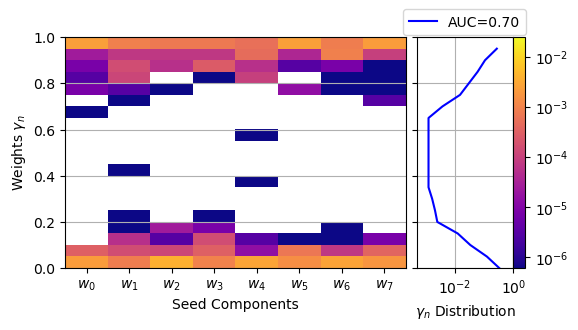

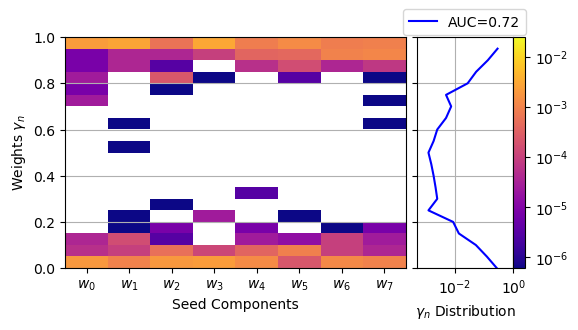

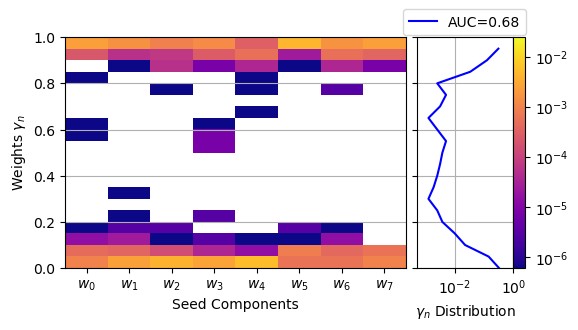

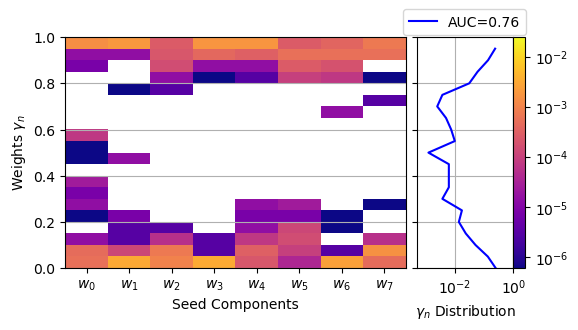

In [62]:
for ds in ["MNIST", "FashionMNIST", "CIFAR10", "SVHN"]:
    df_gn = format_cols(pd.read_csv(f"results/results_lmt_{ds}_wrn_sg2_ubtgn.csv"), reduce_channels=True)
    check_genome_mag(df_gn["genome"], ds, fold=False)
    #plot_genome_usage(df_gn["genome"], title=ds)

In [ ]:
dfs = [pd.read_csv(f"results/results_lmt_Imagenet_wrn_sgXL_ubtgn_{i}.csv") for i in range(10)]
im_smoo_df = pd.concat(dfs, ignore_index=True)
im_smoo_df = format_cols(im_smoo_df, reduce_channels=True)
check_genome_mag(im_smoo_df["genome"], "Imagenet", fold=False)
plot_genome_usage(im_smoo_df["genome"], title="Imagenet")

### Plot genome usage (Distribution view)
For these plots the genomes were only recorded in WanDB, plotting was done with the queried data using the function below.
Note that later in the project we added genome usage to the standard data collection in the DFs, as such for replication wandb is not needed.

For $\omega = \{\omega_{dcb}, \omega_{d2}\}$ the genome data is already logged in the csv and as such can be plotted with `plot_genome_usage`.